# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [5]:
import numpy as np
from sklearn import metrics

In [6]:
# Ginni de cada rama que parti. Gini muestra la diferencia entre las dos clases
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [7]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    #la ganancia media en gini inicial mas la suma ponderada de gini lado izq y gini lado derecho. Porcentaje hay en la izq y hay en la derecha
    # Por que se pondera? Sino se pondera se podría llegar a tener una partición que envíe al izquierdo ej. 
    # yo quiero generar ramas que dejen en un lado todos los unos y en otro todos los ceros. Es mejor el valor alto de gini.
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [8]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    # Calculo todos los posibles splits que se van a utilizar
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        # Guardo los mejores split en j
        # Para saber que no sigo partiendo mas, miro la mínima ganancia
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [9]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    # devulve la variable, la ganancia y el corte
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    # la predicción en ese nodo (requiree el promedio ajustado por laplace)
    y_pred = int(y.mean() >= 0.5) 
    #La probabilidad es la proporción del uno u otro
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    #Selecciono la máxima ganancia
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    # PArto el x del lado derecho e izquierdo
    # split = -1, es el criterio de parada. (split es el indice de la variable)
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain

    # Next iteration to each split
    # PAra cada partición se vuelve a iterar toda la función
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [10]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted   

Text(0, 0.5, 'Accuracy')

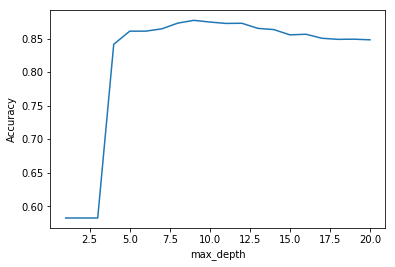

In [11]:
import matplotlib.pyplot as plt
max_depth_range = range(1, 21)

accuracy_scores = []
for depth in max_depth_range:
    tree=tree_grow(X_train, y_train, level=3, min_gain=0.001, max_depth=depth, num_pct=10)
    y_pred=tree_predict(X_test, tree)
    accuracy_scores.append(metrics.accuracy_score(y_pred, y_test))
    
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [12]:
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.8771889400921659, 9)

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [13]:
import numpy as np
#Número de árboles
n_estimators = 10

# Semilla
np.random.seed(123)

# Ejemplos de muestra
n_samples = X_train.shape[0]

# Crear el muestreo aleatorio(will be used to select rows from the DataFrame)

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [14]:
# Crear los árboles
predic = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    predic[i] = tree_predict(X_test, tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=i, num_pct=10))


In [15]:
predic = (predic.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

In [16]:
#Se seleccionan las predicciones que dieron mas de 50% como positiva.

from sklearn import metrics
print('F1 score: ',round(metrics.f1_score(predic, y_test),4))
print('Accuracy: ',round(metrics.accuracy_score(predic, y_test),4))

F1 score:  0.8939
Accuracy:  0.87


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

#Seleccionar las variables aleatorias por nodo

Evaluate the accuracy on the testing set

In [17]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10,max_features=len(X.columns)):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    # devulve la variable, la ganancia y el corte
    j, split, gain = best_split(X, y, num_pct,max_features)
    
    # save tree and estimate prediction
    # la predicción en ese nodo (requiree el promedio ajustado por laplace)
    y_pred = int(y.mean() >= 0.5) 
    #La probabilidad es la proporción del uno u otro
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    #Selecciono la máxima ganancia
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    # PArto el x del lado derecho e izquierdo
    # split = -1, es el criterio de parada. (split es el indice de la variable)
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain
   
    # Next iteration to each split
    # PAra cada partición se vuelve a iterar toda la función
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    
    return tree

In [18]:
def best_split(X, y, num_pct=10,max_features=len(X.columns)):
   
    Xa = X.sample(max_features, axis=1)
    
    features = range(Xa.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    # Calculo todos los posibles splits que se van a utilizar
    for j in features:
        
        splits = np.percentile(Xa.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        # Guardo los mejores split en j
        # Para saber que no sigo partiendo mas, miro la mínima ganancia
        for split in splits:
            gain = gini_impurity(Xa.iloc[:, j], y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]
  
    col = Xa.columns[best_split[0]]
    best_split[0] = X.columns.get_loc(col)
    return best_split

In [19]:
#X_train
tree=tree_grow(X_train, y_train, level=3, min_gain=0.001, max_depth=6, num_pct=10,max_features=5)
#tree
y_pred=tree_predict(X_test, tree)
   
print(metrics.accuracy_score(y_pred, y_test))
print(metrics.f1_score(y_pred, y_test))



0.8566820276497696
0.8787524366471735


# Exercise 11.4

Random forest manual

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [20]:
n_estimators = 10

# Semilla
np.random.seed(123)

# Ejemplos de muestra
n_samples = X_train.shape[0]

# Crear el muestreo aleatorio(will be used to select rows from the DataFrame)

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

In [21]:
import math
n_features=0
n_features = X_train.shape[1]
predic = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))

for i in range(10):
    predic[i] = tree_predict(X_test, tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=i, num_pct=10,max_features=int(math.log(n_features))))


In [22]:
predic = (predic.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

In [23]:
print('F1 score: ',round(metrics.f1_score(predic, y_test),4))
print('Accuracy: ',round(metrics.accuracy_score(predic, y_test),4))

F1 score:  0.8785
Accuracy:  0.8424


# Exercise 11.5

Utilice sklearn

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [28]:
#max_features='auto' elige de manera aleatoria cada variable
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=6, n_estimators = 10,max_features=5,random_state=123)
X= clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('F1 score: ',round(metrics.f1_score(y_pred, y_test),4))
print('Accuracy: ',round(metrics.accuracy_score(y_pred, y_test),4))

F1 score:  0.9019
Accuracy:  0.8811


# Exercise 11.6

Utilice sklearn

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [29]:
from sklearn.model_selection import cross_val_score
max_depth_range = range(1, 12)
estimator_range = range(1, 16, 2)
feature_range = range(1,X_train.shape[1])
semilla = range(1,101,10)
accuracy_scores = []
a= 0
md = 0
et = 0
ft = 0
sm = 0
for max_depth in max_depth_range: 
    for estimator in estimator_range:
        for feature in feature_range:
            for sem in semilla:
                clf = RandomForestClassifier(max_depth=max_depth, n_estimators = estimator,max_features=feature,random_state=sem)
                accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())
                ac=cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
                if ac >= a:
                    a=ac
                    md = max_depth
                    et = estimator
                    ft = feature
                    sm = sem
print('Accuracy: ',  a,'Max depth: ',md, 'Estimadores: ',et, 'Feature: ',ft,'Semilla: ',sm)
            


Accuracy:  0.8859240894046355 Max depth:  8 Estimadores:  15 Feature:  2 Semilla:  41
